In [1]:
from cartoGRAPHs import *
from matplotlib import pyplot as plt

In [2]:
def rgb_to_hex(r, g, b):
    """Convert RGB color to HEX color."""
    # Ensure RGB values are within the correct range
    r = max(0, min(r, 255))
    g = max(0, min(g, 255))
    b = max(0, min(b, 255))

    # Convert and return the HEX color code
    return "#{:02X}{:02X}{:02X}".format(r, g, b)


# modified - with norm
def get_posG_sphere_norm(G, DM, sphere_mapper, d_param, radius_rest_genes = 1):
    '''
    Generate coordinates from embedding.
    Input:
    - G = Graph
    - l_genes = list of node IDs, either specific or all nodes in the graph
    - sphere_mapper = embedding from UMAP spherical embedding
    - d_param = dictionary with nodes as keys and assigned radius as values
    - radius_rest_genes = int; radius in case of genes e.g. not function associated if genes not all G.nodes()

    Return dictionary with nodes as keys and coordinates as values in 3D.
    '''

    x = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
    y = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
    z = np.cos(sphere_mapper.embedding_[:, 0])

    genes = []
    for i in G.nodes():
        if i in DM.index:
            genes.append(i)
    genes_rest = []
    for i in G.nodes():
        if i not in genes:
            genes_rest.append(i)
    posG_3Dsphere = {}
    cc = 0
    for entz in genes:
        posG_3Dsphere[entz] = (x[cc],y[cc], z[cc])
        cc += 1

    # generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
    indices = arange(0, len(genes_rest))
    phi = arccos(1 - 2*indices/len(genes_rest))
    theta = pi * (1 + 5**0.5) * indices

    r_rest = radius_rest_genes # radius for rest genes (e.g. if functional layout)
    x, y, z = r_rest*cos(theta) * sin(phi), r_rest*sin(theta) * sin(phi), r_rest*cos(phi)

    rest_points = []
    for i,j,k in zip(x,y,z):
        rest_points.append((i,j,k))

    posG_rest = dict(zip(genes_rest, rest_points))
    posG_all = {**posG_3Dsphere, **posG_rest}

    posG_3Dsphere_radius = {}
    for node,rad in d_param.items():
        for k,v in posG_all.items():
            if node == k:
                posG_3Dsphere_radius[k] = (v[0]*rad, v[1]*rad, v[2]*rad)

    #posG_complete_sphere = {key:posG_3Dsphere_radius[key] for key in G.nodes()}

    # normalize coordinates
    x_list = []
    y_list = []
    z_list = []
    for k,v in posG_3Dsphere_radius.items():
        x_list.append(v[0])
        y_list.append(v[1])
        z_list.append(v[2])

    xx_norm = preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
    yy_norm = preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
    zz_norm = preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

    posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

    return posG_complete_sphere_norm


## Data

In [3]:
# Salvo's PPI

df = pd.read_csv('input/PPI/autocore_symbol_lcc.csv')
df

symbol1   symbol2
0           TNMD     SPAG4
1           TNMD   BCL2L13
2           TNMD    BNIP3L
3           TNMD      CD33
4           TNMD     HHLA2
...          ...       ...
482930  HS3ST3A2    HS3ST5
482931  DEFB103B  DEFB103B
482932  DEFB103A  DEFB103A
482933     CBLN2     CBLN3
482934     CBLN3     CBLN1

[482935 rows x 2 columns]

In [4]:
G = nx.Graph()

for index, row in df.iterrows():
    G.add_edge(row['symbol1'], row['symbol2'])

print("Nodes: ", G.number_of_nodes())
print("Edges: ", G.number_of_edges())

Nodes:  18815
Edges:  482935


In [5]:
# remove self-loops

self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)
print("Edges after removing self-loops: ", G.number_of_edges())

Edges after removing self-loops:  478345


# figure 3a

In [ ]:
# EXPOSURES

# central module: Endrin
# peripheral module : Vanillic acid / OLD : Diflubenzuron
# hub exposure : Methylmethacrylate / OLD : Benthiocarb

# figure 3A
# highlight 3 exposures in the ppi
# node size = degree
# node labels for exposures only

In [ ]:
genes_endrin = [line.strip() for line in open('output/Endrin_genes.txt')]
genes_mma = [line.strip() for line in open('output/Methylmethacrylate.txt')]
genes_vani = [line.strip() for line in open('output/Vanillic_acid.txt')]


## Layout

In [7]:
r = 0.9
alpha = 1.0

A = nx.adjacency_matrix(G, nodelist=list(G.nodes()))
DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_structural = pd.DataFrame(DM_m)
FM_structural.sum(axis=1) # axis=1 for columns i.e. features = sum 1
FM_structural.index=list(G.nodes())
FM_structural.columns=list(G.nodes())
FM_structural

TNMD         SPAG4       BCL2L13        BNIP3L          CD33  \
TNMD     9.002535e-01  3.603373e-03  1.072419e-03  2.003539e-03  2.501761e-03   
SPAG4    5.004684e-03  9.004001e-01  1.021895e-05  1.120234e-05  2.133985e-05   
BCL2L13  5.004620e-03  3.433568e-05  9.003257e-01  1.522161e-05  1.730704e-05   
BNIP3L   5.008848e-03  2.016422e-05  8.154435e-06  9.001618e-01  1.679813e-05   
CD33     5.003522e-03  3.072939e-05  7.417302e-06  1.343851e-05  9.002449e-01   
...               ...           ...           ...           ...           ...   
TAS1R1   4.415865e-12  1.188752e-12  4.781909e-12  1.103886e-11  5.943778e-12   
TAS1R2   4.415865e-12  1.188752e-12  4.781909e-12  1.103886e-11  5.943778e-12   
CYP2A13  1.101571e-12  1.380958e-11  5.333677e-12  8.411263e-12  9.981912e-12   
CBLN2    1.078897e-12  5.540339e-13  9.635416e-12  5.120562e-12  2.624768e-12   
CBLN1    1.078897e-12  5.540339e-13  9.635416e-12  5.120562e-12  2.624768e-12   

                HHLA2       FAM209A          MYG1        FCGR1A       CREB3L1  \
TNMD     6.432993e-03  3.900740e-04  1.452384e-03  1.916313e-03  4.358743e-04   
SPAG4    1.285408e-04  8.278749e-06  8.160925e-06  2.097310e-05  1.020807e-05   
BCL2L13  5.427318e-05  3.610406e-05  9.280860e-06  2.134328e-05  2.785558e-05   
BNIP3L   4.686277e-05  9.164272e-06  8.198149e-06  2.025597e-05  6.365291e-06   
CD33     5.130180e-05  7.284138e-06  8.123345e-06  1.700323e-05  5.302049e-06   
...               ...           ...           ...           ...           ...   
TAS1R1   1.995169e-12  3.978579e-11  1.490480e-11  9.275378e-11  2.896482e-11   
TAS1R2   1.995169e-12  3.978579e-11  1.490480e-11  9.275378e-11  2.896482e-11   
CYP2A13  4.865784e-13  3.351328e-12  3.277935e-12  9.572446e-12  1.261423e-11   
CBLN2    6.918972e-13  4.760578e-12  1.715077e-12  8.469620e-12  4.686345e-12   
CBLN1    6.918972e-13  4.760578e-12  1.715077e-12  8.469620e-12  4.686345e-12   

         ...         FGF20       MRGPRX2     LINC00471      PRAMEF15  \
TNMD     ...  7.449656e-11  4.892082e-11  8.098252e-10  4.014179e-11   
SPAG4    ...  5.334358e-10  1.304032e-10  1.197500e-09  1.889831e-11   
BCL2L13  ...  2.890845e-09  3.349586e-09  1.623190e-09  1.404032e-09   
BNIP3L   ...  1.999156e-09  2.268541e-10  9.876792e-10  4.741151e-09   
CD33     ...  2.205544e-09  7.828557e-09  2.400468e-10  5.671796e-11   
...      ...           ...           ...           ...           ...   
TAS1R1   ...  3.134062e-13  2.758629e-13  7.229914e-13  6.279638e-14   
TAS1R2   ...  3.134062e-13  2.758629e-13  7.229914e-13  6.279638e-14   
CYP2A13  ...  5.147225e-14  4.092861e-15  5.548196e-13  4.371445e-15   
CBLN2    ...  1.647750e-12  9.381090e-15  1.241855e-13  8.217554e-15   
CBLN1    ...  1.647750e-12  9.381090e-15  1.241855e-13  8.217554e-15   

              PRAMEF4        TAS1R1        TAS1R2       CYP2A13         CBLN2  \
TNMD     4.014179e-11  7.948557e-11  7.948557e-11  1.982829e-11  1.942014e-11   
SPAG4    1.889831e-11  2.971880e-11  2.971880e-11  3.452394e-10  1.385085e-11   
BCL2L13  1.404032e-09  4.016804e-10  4.016804e-10  4.480288e-10  8.093750e-10   
BNIP3L   4.741151e-09  4.967487e-10  4.967487e-10  3.785068e-10  2.304253e-10   
CD33     5.671796e-11  2.139760e-10  2.139760e-10  3.593488e-10  9.449165e-11   
...               ...           ...           ...           ...           ...   
TAS1R1   6.279638e-14  9.030201e-01  3.020148e-03  8.829353e-15  7.292569e-15   
TAS1R2   6.279638e-14  3.020148e-03  9.030201e-01  8.829353e-15  7.292569e-15   
CYP2A13  4.371445e-15  8.829353e-15  8.829353e-15  9.045272e-01  5.311115e-16   
CBLN2    8.217554e-15  7.292569e-15  7.292569e-15  5.311115e-16  9.030208e-01   
CBLN1    8.217554e-15  7.292569e-15  7.292569e-15  5.311115e-16  3.020810e-03   

                CBLN1  
TNMD     1.942014e-11  
SPAG4    1.385085e-11  
BCL2L13  8.093750e-10  
BNIP3L   2.304253e-10  
CD33     9.449165e-11  
...               ...  
TAS1R1   7.292569e-15  
TAS1R2   7.292569e-15  
CYP2A13  5.311115

In [8]:
d_exposure_1 = {}
for g in G.nodes():
    if g in genes_endrin:
        d_exposure_1[g] = 1
    else:
        d_exposure_1[g] = 0

d_exposure_2 = {}
for g in G.nodes():
    if g in genes_mma: #diflu
        d_exposure_2[g] = 1
    else:
        d_exposure_2[g] = 0

d_exposure_3 = {}
for g in G.nodes():
    if g in genes_vani:
        d_exposure_3[g] = 10
    else:
        d_exposure_3[g] = 0

genes_prostate = [line.strip() for line in open('output/Prostatic_Neoplasms.txt')]
genes_achrom = [line.strip() for line in open('output/Cataract.txt')]

d_disease_1 = {}
for g in G.nodes():
    if g in genes_prostate:
        d_disease_1[g] = 1
    else:
        d_disease_1[g] = 0

d_disease_2 = {}
for g in G.nodes():
    if g in genes_achrom:
        d_disease_2[g] = 10
    else:
        d_disease_2[g] = 0

FM_ex_di = pd.DataFrame(d_exposure_2.values()) #d_exposure_1.values())
FM_ex_di['prostate'] = d_disease_1.values()
FM_ex_di['cat'] = d_disease_2.values()
FM_ex_di['endrin'] = d_exposure_1.values()
FM_ex_di['vanillic acid'] = d_exposure_3.values()

FM_ex_di.columns = [
                    'mma',
                    'prostate',
                    'cat',
                    'endrin',
                    'vanillic acid']
FM_ex_di.index = list(G.nodes())
FM_ex_di

mma  prostate  cat  endrin  vanillic acid
TNMD       0         0    0       0              0
SPAG4      0         0    0       0              0
BCL2L13    0         0    0       0              0
BNIP3L     0         0    0       0              0
CD33       0         0    0       0              0
...      ...       ...  ...     ...            ...
TAS1R1     0         0    0       0              0
TAS1R2     0         0    0       0              0
CYP2A13    0         0    0       0              0
CBLN2      0         0    0       0              0
CBLN1      0         0    0       0              0

[18815 rows x 5 columns]

In [9]:
scalar_val = 2 #2

DF_structural = FM_structural
DF_functional = FM_ex_di.T
DF_merge = feature_modulation(DF_structural,DF_functional, scalar_val)
DF_merge

TNMD         SPAG4       BCL2L13        BNIP3L          CD33  \
TNMD     7.314436e-01  4.066237e-03  4.066185e-03  4.069620e-03  4.065293e-03   
SPAG4    2.927691e-03  7.315626e-01  2.789726e-05  1.638315e-05  2.496720e-05   
BCL2L13  8.713253e-04  8.302757e-06  7.315022e-01  6.625366e-06  6.026456e-06   
BNIP3L   1.627848e-03  9.101750e-06  1.236735e-05  7.313691e-01  1.091860e-05   
CD33     2.032646e-03  1.733834e-05  1.406173e-05  1.364825e-05  7.314366e-01   
...               ...           ...           ...           ...           ...   
TAS1R1   6.458093e-11  2.414612e-11  3.263598e-10  4.036015e-10  1.738526e-10   
TAS1R2   6.458093e-11  2.414612e-11  3.263598e-10  4.036015e-10  1.738526e-10   
CYP2A13  1.611021e-11  2.805023e-10  3.640173e-10  3.075316e-10  2.919660e-10   
CBLN2    1.577860e-11  1.125362e-11  6.576060e-10  1.872174e-10  7.677317e-11   
CBLN1    1.577860e-11  1.125362e-11  6.576060e-10  1.872174e-10  7.677317e-11   

                HHLA2       FAM209A          MYG1        FCGR1A       CREB3L1  \
TNMD     4.065225e-03  4.084872e-03  4.064589e-03  4.065443e-03  4.072632e-03   
SPAG4    5.848508e-05  6.242071e-05  1.644399e-05  3.203586e-05  6.867362e-05   
BCL2L13  7.349368e-06  8.101785e-05  5.565660e-06  9.702771e-06  5.577240e-05   
BNIP3L   1.184567e-05  3.838747e-05  9.177216e-06  1.718915e-05  2.378987e-05   
CD33     1.620967e-05  3.813991e-05  1.136685e-05  1.803610e-05  2.477009e-05   
...               ...           ...           ...           ...           ...   
TAS1R1   2.269466e-11  7.499494e-09  7.508165e-10  3.541975e-09  4.871437e-09   
TAS1R2   2.269466e-11  7.499494e-09  7.508165e-10  3.541975e-09  4.871437e-09   
CYP2A13  5.534735e-12  6.317147e-10  1.651232e-10  3.655416e-10  2.121520e-09   
CBLN2    7.870197e-12  8.973538e-10  8.639553e-11  3.234281e-10  7.881713e-10   
CBLN1    7.870197e-12  8.973538e-10  8.639553e-11  3.234281e-10  7.881713e-10   

         ...        TAS1R1        TAS1R2       CYP2A13         CBLN2  \
TNMD     ...  3.587829e-12  3.587829e-12  8.950116e-13  8.765887e-13   
SPAG4    ...  9.658447e-13  9.658447e-13  1.122009e-11  4.501449e-13   
BCL2L13  ...  3.885236e-12  3.885236e-12  4.333539e-12  7.828643e-12   
BNIP3L   ...  8.968921e-12  8.968921e-12  6.834035e-12  4.160386e-12   
CD33     ...  4.829238e-12  4.829238e-12  8.110166e-12  2.132588e-12   
...      ...           ...           ...           ...           ...   
TAS1R1   ...  7.336914e-01  2.453828e-03  7.173727e-15  5.925111e-15   
TAS1R2   ...  2.453828e-03  7.336914e-01  7.173727e-15  5.925111e-15   
CYP2A13  ...  7.173727e-15  7.173727e-15  7.349159e-01  4.315208e-16   
CBLN2    ...  5.925111e-15  5.925111e-15  4.315208e-16  7.336920e-01   
CBLN1    ...  5.925111e-15  5.925111e-15  4.315208e-16  2.454367e-03   

                CBLN1  mma  prostate  cat  endrin  vanillic acid  
TNMD     8.765887e-13  0.0       0.0  0.0     0.0            0.0  
SPAG4    4.501449e-13  0.0       0.0  0.0     0.0            0.0  
BCL2L13  7.828643e-12  0.0       0.0  0.0     0.0            0.0  
BNIP3L   4.160386e-12  0.0       0.0  0.0     0.0            0.0  
CD33     2.132588e-12  0.0       0.0  0.0     0.0            0.0  
...               ...  ...       ...  ...     ...            ...  
TAS1R1   5.925111e-15  0.0       0.0  0.0     0.0            0.0  
TAS1R2   5.925111e-15  0.0       0.0  0.0     0.0            0.0  
CYP2A13  4.315208e-16  0.0       0.0  0.0     0.0            0.0  
CBLN2    2.454367e-03  0.0       0.0  0.0     0.0            0.0  
CBLN1    7.336920e-01  0.0       0.0  0.0     0.0            0.0  

[18815 rows x 18820 columns]

In [10]:
# 3d spherical layout first
n_n = 10 #10
spr = 1.0
md = 0.9 #0.9

umap_sphere = embed_umap_sphere(DF_merge, #FM_structural,
                                n_n, spr, md)

/opt/anaconda3/envs/Epigenetics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Epigenetics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
##########################################################
#
# RADIUS / SPHERE LAYERS determined by specific exposures / diseases
#
##########################################################

d_radius = {}
for g in G.nodes():
    # central
    if g in genes_endrin:
        d_radius[g] = 0.1
    elif g in genes_mma:
        d_radius[g] = 0.2
    elif g in genes_prostate:
        d_radius[g] = 0.2
    # bit further out
    elif g in genes_achrom:
        d_radius[g] = 0.5
    # periphery
    elif g in genes_vani:
        d_radius[g] = 0.5
    else:
        d_radius[g] = 0.5


In [12]:
posG3D = get_posG_sphere_norm(G, FM_structural, umap_sphere, d_radius)

# for g in G.nodes():
#     if g not in posG3D.keys():
#         print('error', g)

# posG3D_sorted = {key:posG3D[key] for key in G.nodes() if key in posG3D}

df_posG3D = pd.DataFrame(posG3D).T

In [13]:
n_n = 10
spr = 1.0
md = 0.0
metr2D = 'cosine' #'cosine'

posG2D = layout_portrait_umap(G,
                                df_posG3D,
                                2,
                                n_neighbors=n_n,
                                spread=spr,
                                min_dist=md,
                                metric=metr2D
                                )

/opt/anaconda3/envs/Epigenetics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Epigenetics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Visual settings

In [14]:
opacity_nodes = 0.9
node_edge_col = '#000000'
node_linewidth = 1

edge_opacity = 0.1
edge_width = 0.5
edge_color = '#A1A1A1' #'#6C6C6C' #'#d3d3d3'

scale_factor = 0.05
d_size = draw_node_degree(G, scale_factor)
node_size = list(d_size.values())

In [15]:
len(d_size)

18815

In [16]:
# exposures
color_1 = '#F15A29' # rgb_to_hex(241, 90, 41)
color_2 = '#FBB040' # rgb_to_hex(251, 176, 64)
color_3 = '#f79d8d' #'#ffe000' #rgb_to_hex(254,105,138)

# diseases
color_2_diseases = '#157DA4' # rgb_to_hex(0, 174, 239)
color_3_diseases = '#44C8F5' #rgb_to_hex(68, 200, 245)


In [17]:
# highlight specific edges of modules
edges_1 = []
edges_2 = []
edges_3 = []

for e in G.edges():
    if e[0] in genes_endrin and e[1] in genes_endrin:
        edges_1.append(e)

for e in G.edges():
    if e[0] in genes_mma and e[1] in genes_mma: # HUB EXPOSURE!
        edges_2.append(e)
    #elif e[0] == 'IL6' or e[1] == 'IL6':
    elif e[0] == 'TNF' or e[1] == 'TNF':
    #elif e[0] == 'GSTA1' or e[1] == 'GSTA1':
        edges_2.append(e)

for e in G.edges():
    if e[0] in genes_vani and e[1] in genes_vani:
        edges_3.append(e)

nodecolor_1 = []
d_nodesize_1 = {}

for g in G.nodes():
    if g in genes_endrin:
        d_nodesize_1[g] = d_size[g]
        nodecolor_1.append(color_1)

nodecolor_2 = []
d_nodesize_2 = {}

for g in G.nodes():
    if g in genes_mma:
        d_nodesize_2[g] = d_size[g]
        nodecolor_2.append(color_2)

nodecolor_3 = []
d_nodesize_3 = {}

for g in G.nodes():
    if g in genes_vani:
        d_nodesize_3[g] = d_size[g]
        nodecolor_3.append(color_3)


# highlight specific edges of modules

edges_1_diseases = []
edges_2_diseases = []
edges_3_diseases = []

for e in G.edges():
    if e[0] in genes_endrin and e[1] in genes_endrin:
        edges_1_diseases.append(e)

for e in G.edges():
    if e[0] in genes_prostate and e[1] in genes_prostate:
        edges_2_diseases.append(e)

for e in G.edges():
    if e[0] in genes_achrom and e[1] in genes_achrom:
        edges_3_diseases.append(e)

nodecolor_1_diseases = []
d_nodesize_1_diseases = {}

for g in G.nodes():
    if g in genes_endrin:
        d_nodesize_1_diseases[g] = d_size[g]
        nodecolor_1_diseases.append(color_1)

nodecolor_2_diseases = []
d_nodesize_2_diseases = {}

for g in G.nodes():
    if g in genes_prostate:
        d_nodesize_2_diseases[g] = d_size[g]
        nodecolor_2_diseases.append(color_2)

nodecolor_3_diseases = []
d_nodesize_3_diseases = {}

for g in G.nodes():
    if g in genes_achrom:
        d_nodesize_3_diseases[g] = d_size[g]
        nodecolor_3_diseases.append(color_3)

G_1 = G.subgraph(genes_endrin)
G_2 = G.subgraph(genes_mma)
G_3 = G.subgraph(genes_vani)

posG2D_1 = {k: posG2D[k] for k in G_1.nodes()}
posG2D_2 = {k: posG2D[k] for k in G_2.nodes()}
posG2D_3 = {k: posG2D[k] for k in G_3.nodes()}


#-----------------------------------------------------------

edges_2_diseases = []
edges_3_diseases = []

for e in G.edges():
    if e[0] in genes_prostate and e[1] in genes_prostate:
        edges_2_diseases.append(e)

for e in G.edges():
    if e[0] in genes_achrom and e[1] in genes_achrom:
        edges_3_diseases.append(e)

nodecolor_2_diseases = []
d_nodesize_2_diseases = {}

for g in G.nodes():
    if g in genes_prostate:
        d_nodesize_2_diseases[g] = d_size[g]
        nodecolor_2_diseases.append(color_2_diseases)

nodecolor_3_diseases = []
d_nodesize_3_diseases = {}

for g in G.nodes():
    if g in genes_achrom:
        d_nodesize_3_diseases[g] = d_size[g]
        nodecolor_3_diseases.append(color_3_diseases)

G_2_diseases = G.subgraph(genes_prostate)
G_3_diseases = G.subgraph(genes_achrom)

posG2D_1_diseases = {k: posG2D[k] for k in G_1.nodes()}
posG2D_2_diseases = {k: posG2D[k] for k in G_2_diseases.nodes()}
posG2D_3_diseases = {k: posG2D[k] for k in G_3_diseases.nodes()}


#-----------------------------------------------------------
# sort all according to subgraph nodes order

d_nodesize_1 = {k: d_nodesize_1[k] for k in G_1.nodes()}
d_nodesize_2 = {k: d_nodesize_2[k] for k in G_2.nodes()}
d_nodesize_3 = {k: d_nodesize_3[k] for k in G_3.nodes()}
d_nodesize_1_diseases = {k: d_nodesize_1_diseases[k] for k in G_1.nodes()}
d_nodesize_2_diseases = {k: d_nodesize_2_diseases[k] for k in G_2_diseases.nodes()}
d_nodesize_3_diseases = {k: d_nodesize_3_diseases[k] for k in G_3_diseases.nodes()}

nodesize_1 = list(d_nodesize_1.values())
nodesize_2 = list(d_nodesize_2.values())
nodesize_3 = list(d_nodesize_3.values())
nodesize_1_diseases = list(d_nodesize_1_diseases.values())
nodesize_2_diseases = list(d_nodesize_2_diseases.values())
nodesize_3_diseases = list(d_nodesize_3_diseases.values())

# VISUALIZATION

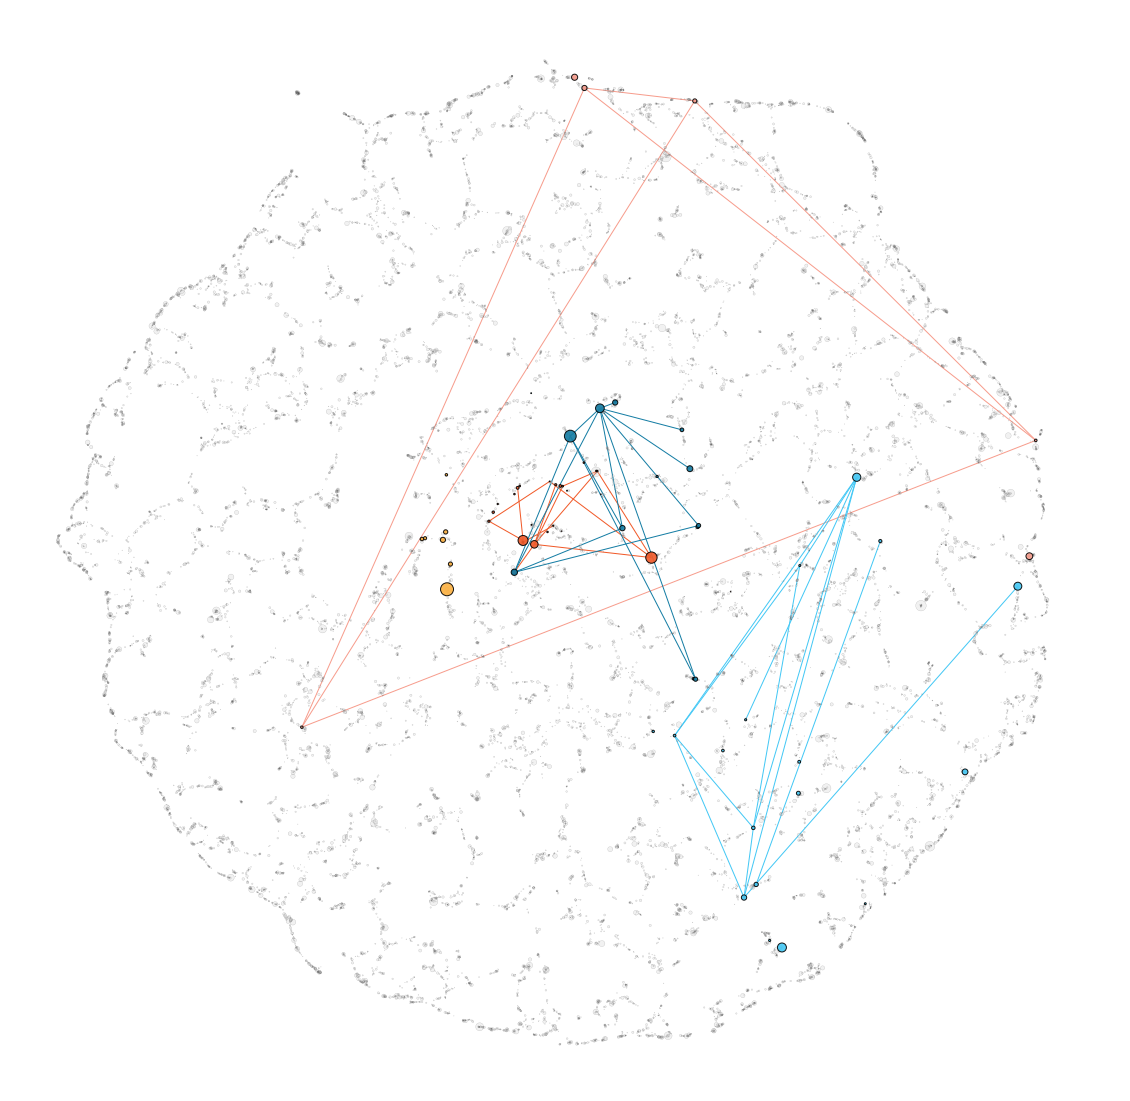

In [ ]:
plt.figure(figsize=(20,20))

# all nodes
nx.draw_networkx_nodes(G, posG2D, edgecolors=node_edge_col, linewidths=0.25, node_color='#d3d3d3', node_size=node_size, alpha=0.3)

#####################
# EXPOSURES
#####################
nx.draw_networkx_nodes(G_1, posG2D_1, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_1, node_size=[i for i in nodesize_1], alpha=0.9)
nx.draw_networkx_nodes(G_2, posG2D_2, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_2, node_size=[i*10 for i in nodesize_2], alpha=0.9)
nx.draw_networkx_nodes(G_3, posG2D_3, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_3, node_size=[i*10 for i in nodesize_3], alpha=0.9)

posG2D_1_labels = {}
y_off = 0.01  # offset on the y axis
for k, v in posG2D_1.items():
    posG2D_1_labels[k] = (v[0], v[1]+y_off)

posG2D_2_labels = {}
for k,v in posG2D_2.items():
    posG2D_2_labels[k] = (v[0], v[1]+y_off)

posG2D_3_labels = {}
for k,v in posG2D_3.items():
    posG2D_3_labels[k] = (v[0], v[1]+y_off)

#nx.draw_networkx_labels(G_1, posG2D_1_labels, font_size=8, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_2, posG2D_2_labels, font_size=8, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_3, posG2D_3_labels, font_size=8, font_color='black', font_family='sans-serif')

# specific edges
nx.draw_networkx_edges(G, posG2D, edgelist=edges_1, edge_color=color_1, width=1, alpha=1)
#nx.draw_networkx_edges(G, posG2D, edgelist=edges_2, edge_color='#a9a9a9', width=0.2, alpha= 0.75) #color_2, width=1, alpha=1)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_3, edge_color=color_3, width=1, alpha=1)

#####################
# DISEASES
#####################
#nx.draw_networkx_nodes(G_1, posG2D, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_1, node_size=[i for i in nodesize_1], alpha=0.9)
nx.draw_networkx_nodes(G_2_diseases, posG2D_2_diseases, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_2_diseases, node_size=[i*2 for i in nodesize_2_diseases], alpha=0.9)
nx.draw_networkx_nodes(G_3_diseases, posG2D_3_diseases, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_3_diseases, node_size=[i*10 for i in nodesize_3_diseases], alpha=0.9)

#nx.draw_networkx_labels(G_1, posG2D_1_labels, font_size=8, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_2_diseases, posG2D_2_diseases, font_size=8, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_3_diseases, posG2D_3_diseases, font_size=8, font_color='black', font_family='sans-serif')

# specific edges
#nx.draw_networkx_edges(G, posG2D, edgelist=edges_1, edge_color=color_1, width=1, alpha=1)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_2_diseases, edge_color=color_2_diseases, width=1, alpha=1)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_3_diseases, edge_color=color_3_diseases,width=1, alpha=1)

# all edges
#nx.draw_networkx_edges(G, posG2D, width=0.05, edge_color='#d3d3d3', alpha=0.01)

plt.axis('off')  # Optional: to hide the axis

plt.savefig('test_layoutall-1.png', dpi=72)
#plt.savefig('Salvo_fig3a.png', dpi=300)

# figure 3a - only exposures

In [18]:
# show other edges
#edges_select = []
#for e in G.edges():
#    if e[0] in genes_endrin or e[0] in genes_mma or e[0] in genes_vani or e[1] in genes_endrin or e[1] in genes_mma or e[1] in genes_vani:
#        edges_select.append(e)

# show hub edges from endrin hub and mma hub in grey
hub_edges = []
for e in G.edges():
    if e[0] == 'TNF' or e[1] == 'TNF' or e[0] == 'ESR2' or e[1] == 'ESR2':
        hub_edges.append(e)
#    if e[0] in genes_endrin or e[0] in genes_mma or e[0] in genes_vani or e[1] in genes_endrin or e[1] in genes_mma or e[1] in genes_vani:
#        edges_select.append(e)


(-0.10499957071800001, 1.104995482318, -0.10377862029450001, 1.1047774877945)

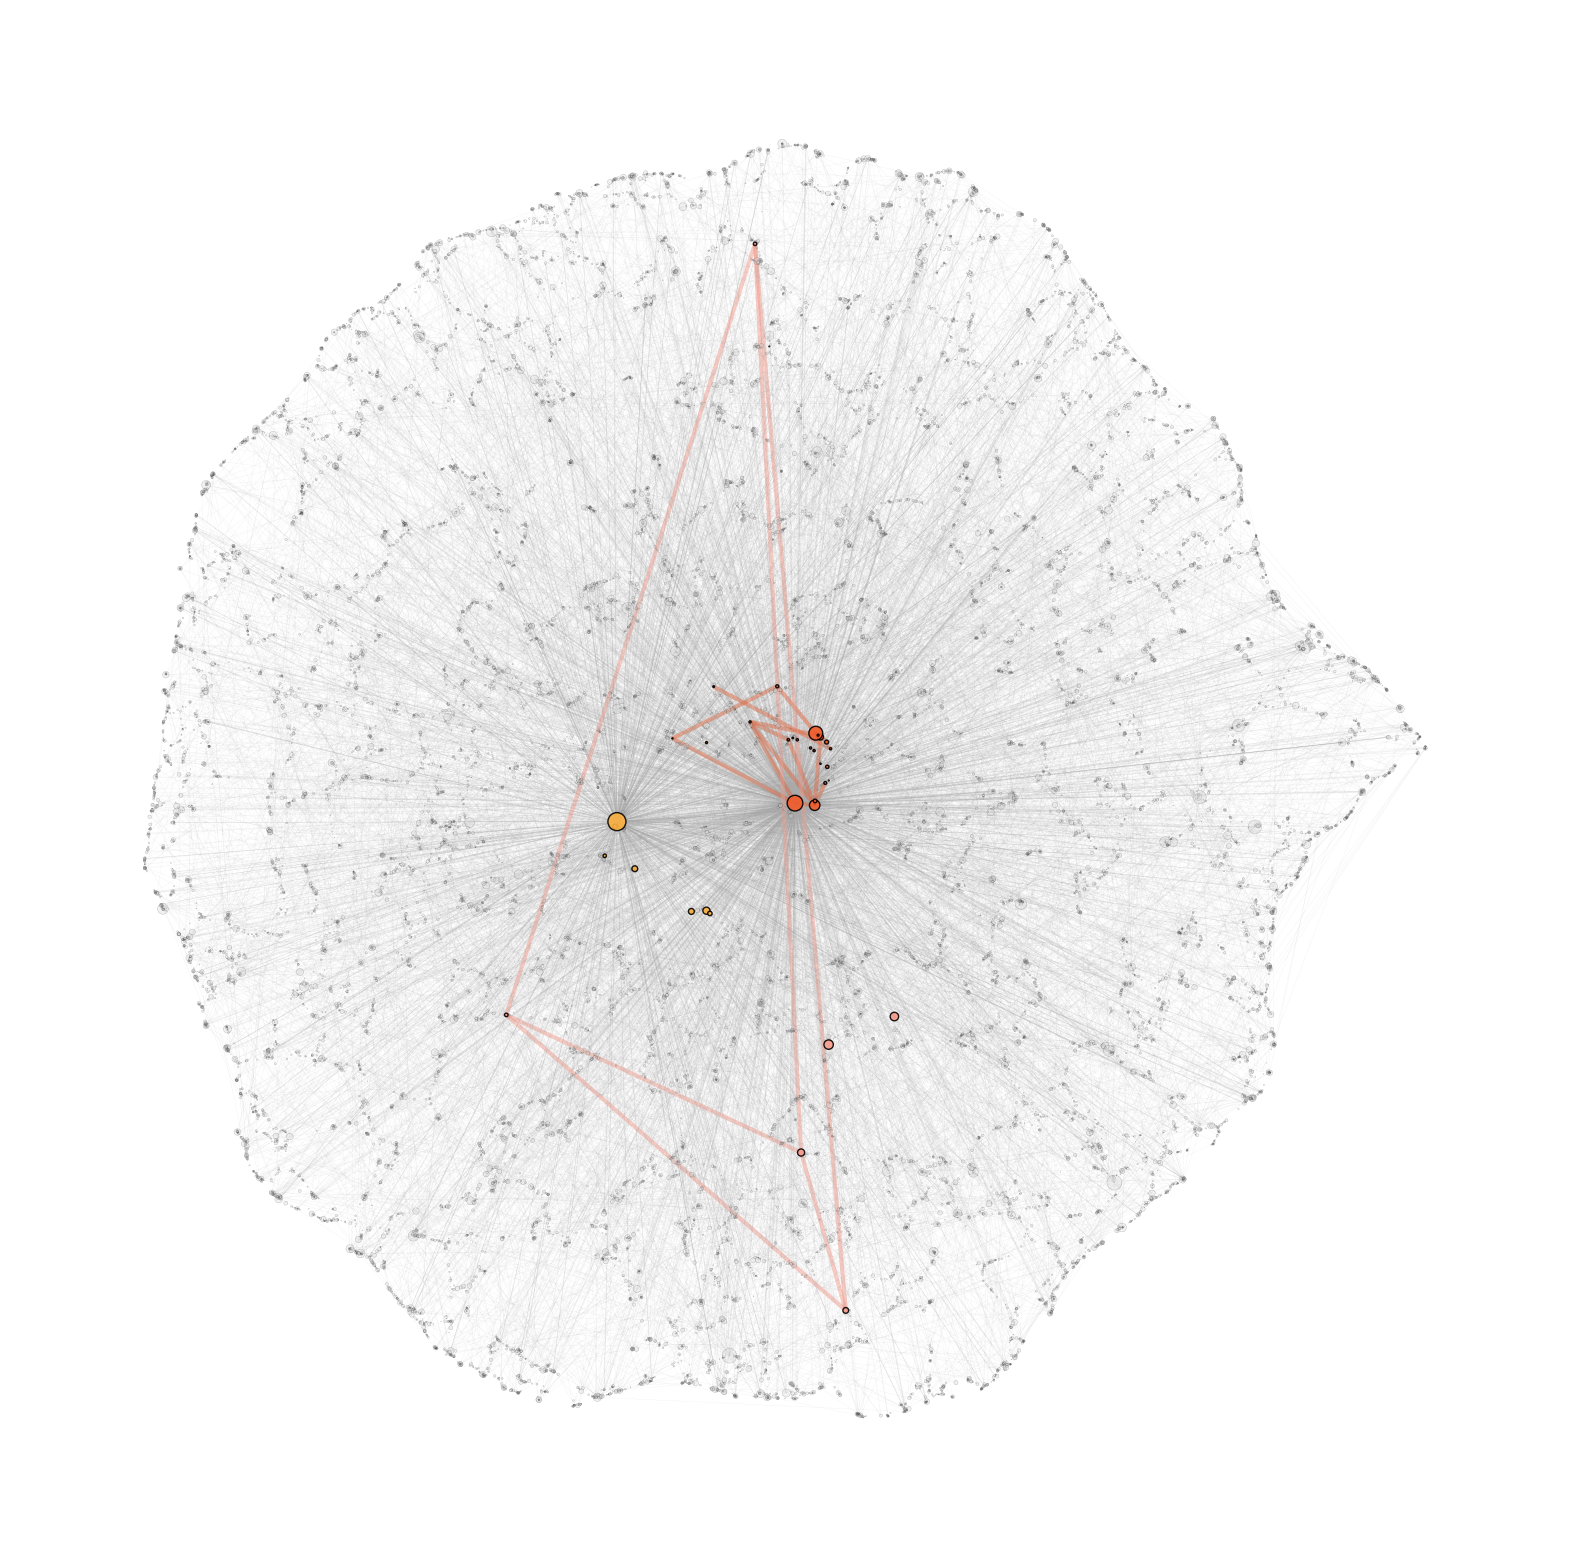

In [19]:
plt.figure(figsize=(20,20))


# hub edges
nx.draw_networkx_edges(G, posG2D, edgelist=hub_edges, edge_color='#a9a9a9', width=0.5, alpha=0.1)
# specific edges
nx.draw_networkx_edges(G, posG2D, edgelist=edges_1, edge_color=color_1, width=3, alpha=0.5)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_2, edge_color='#a9a9a9', width=0.2, alpha=0.5) # edge_color=color_2, width=2.5, alpha=0.5)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_3, edge_color=color_3, width=3, alpha=0.5)
# other edges
nx.draw_networkx_edges(G, posG2D, edgelist=list(G.edges())[::100], edge_color='#a9a9a9', width=0.2, alpha=0.2)



# all nodes
nx.draw_networkx_nodes(G, posG2D, edgecolors=node_edge_col, linewidths=0.25, node_color='#d3d3d3', node_size=node_size, alpha=0.3)

nx.draw_networkx_nodes(G_1, posG2D_1, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_1, node_size=[i for i in nodesize_1], alpha=0.9)
nx.draw_networkx_nodes(G_2, posG2D_2, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_2, node_size=[i*10 for i in nodesize_2], alpha=0.9)
nx.draw_networkx_nodes(G_3, posG2D_3, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_3, node_size=[i*10 for i in nodesize_3], alpha=0.9)

posG2D_1_labels = {}
y_off = 0.01  # offset on the y axis
for k, v in posG2D_1.items():
    posG2D_1_labels[k] = (v[0], v[1]+y_off)

posG2D_2_labels = {}
for k,v in posG2D_2.items():
    posG2D_2_labels[k] = (v[0], v[1]+y_off)

posG2D_3_labels = {}
for k,v in posG2D_3.items():
    posG2D_3_labels[k] = (v[0], v[1]+y_off)

#nx.draw_networkx_labels(G_1, posG2D_1_labels, font_size=8, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_2, posG2D_2_labels, font_size=8, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_3, posG2D_3_labels, font_size=8, font_color='black', font_family='sans-serif')

plt.axis('off')  # Optional: to hide the axis

#plt.savefig('test_fig3a-1.png', dpi=72)
#plt.savefig('Salvo_fig3a.png', dpi=300)


# nx.draw_networkx_labels(G_1, posG2D_1_labels, font_size=14, font_color='black', font_family='sans-serif')
# nx.draw_networkx_labels(G_2, posG2D_2_labels, font_size=14, font_color='black', font_family='sans-serif')
# nx.draw_networkx_labels(G_3, posG2D_3_labels, font_size=14, font_color='black', font_family='sans-serif')

# plt.savefig('Salvo_fig3a-withlabels.png', dpi=300)


In [20]:
import pandas as pd

rows = []

# =====================================================
# -------------------- NODES ---------------------------
# =====================================================

# --- 1) Base layer (all nodes, light gray background) ---
for node, (x, y) in posG2D.items():

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "background",
        "node_color": "#d3d3d3",
        "node_size": node_size,
        "node_alpha": 0.3,
        "node_edgecolor": node_edge_col,
        "node_linewidth": 0.25,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# --- 2) Highlighted community 1 ---
for node, (x, y) in posG2D_1.items():
    idx = list(G_1.nodes()).index(node)

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "G1",
        "node_color": nodecolor_1,
        "node_size": nodesize_1[idx],
        "node_alpha": 0.9,
        "node_edgecolor": node_edge_col,
        "node_linewidth": node_linewidth,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# --- 3) Highlighted community 2 ---
for node, (x, y) in posG2D_2.items():
    idx = list(G_2.nodes()).index(node)

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "G2",
        "node_color": nodecolor_2,
        "node_size": nodesize_2[idx] * 10,
        "node_alpha": 0.9,
        "node_edgecolor": node_edge_col,
        "node_linewidth": node_linewidth,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# --- 4) Highlighted community 3 ---
for node, (x, y) in posG2D_3.items():
    idx = list(G_3.nodes()).index(node)

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "G3",
        "node_color": nodecolor_3,
        "node_size": nodesize_3[idx] * 10,
        "node_alpha": 0.9,
        "node_edgecolor": node_edge_col,
        "node_linewidth": node_linewidth,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# =====================================================
# -------------------- EDGES ---------------------------
# =====================================================

def append_edges(edgelist, category, color, width, alpha):
    for u, v in edgelist:
        rows.append({
            "row_type": "edge",
            "node_id": None,
            "x": None,
            "y": None,
            "node_layer": None,
            "node_color": None,
            "node_size": None,
            "node_alpha": None,
            "node_edgecolor": None,
            "node_linewidth": None,
            "source": u,
            "target": v,
            "edge_category": category,
            "edge_color": color,
            "edge_width": width,
            "edge_alpha": alpha
        })


# hub edges
append_edges(hub_edges, "hub", "#a9a9a9", 0.5, 0.1)

# community edges
append_edges(edges_1, "edges_1", color_1, 3, 0.5)
append_edges(edges_2, "edges_2", "#a9a9a9", 0.2, 0.5)
append_edges(edges_3, "edges_3", color_3, 3, 0.5)

# sampled background edges
append_edges(list(G.edges())[::100], "sampled", "#a9a9a9", 0.2, 0.2)


# =====================================================
# ---------------- SAVE TO EXCEL ----------------------
# =====================================================

df_full_network = pd.DataFrame(rows)

print("Nodes saved:", len(df_full_network[df_full_network["row_type"]=="node"]))
print("Edges saved:", len(df_full_network[df_full_network["row_type"]=="edge"]))

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_full_network.to_excel(writer,
                             sheet_name="Fig3A",
                             index=False)

print("Full styled network saved successfully.")

Nodes saved: 18853
Edges saved: 8020
Full styled network saved successfully.


# figure 4a - endrin with diseases

In [21]:
# show all links which involves one node of the colored nodes
edges_select = []
for e in G.edges():
    if e[0] in genes_endrin or e[0] in genes_prostate or e[0] in genes_achrom or e[1] in genes_endrin or e[1] in genes_prostate or e[1] in genes_achrom:
        edges_select.append(e)


(-0.10499957071800001, 1.104995482318, -0.10377862029450001, 1.1047774877945)

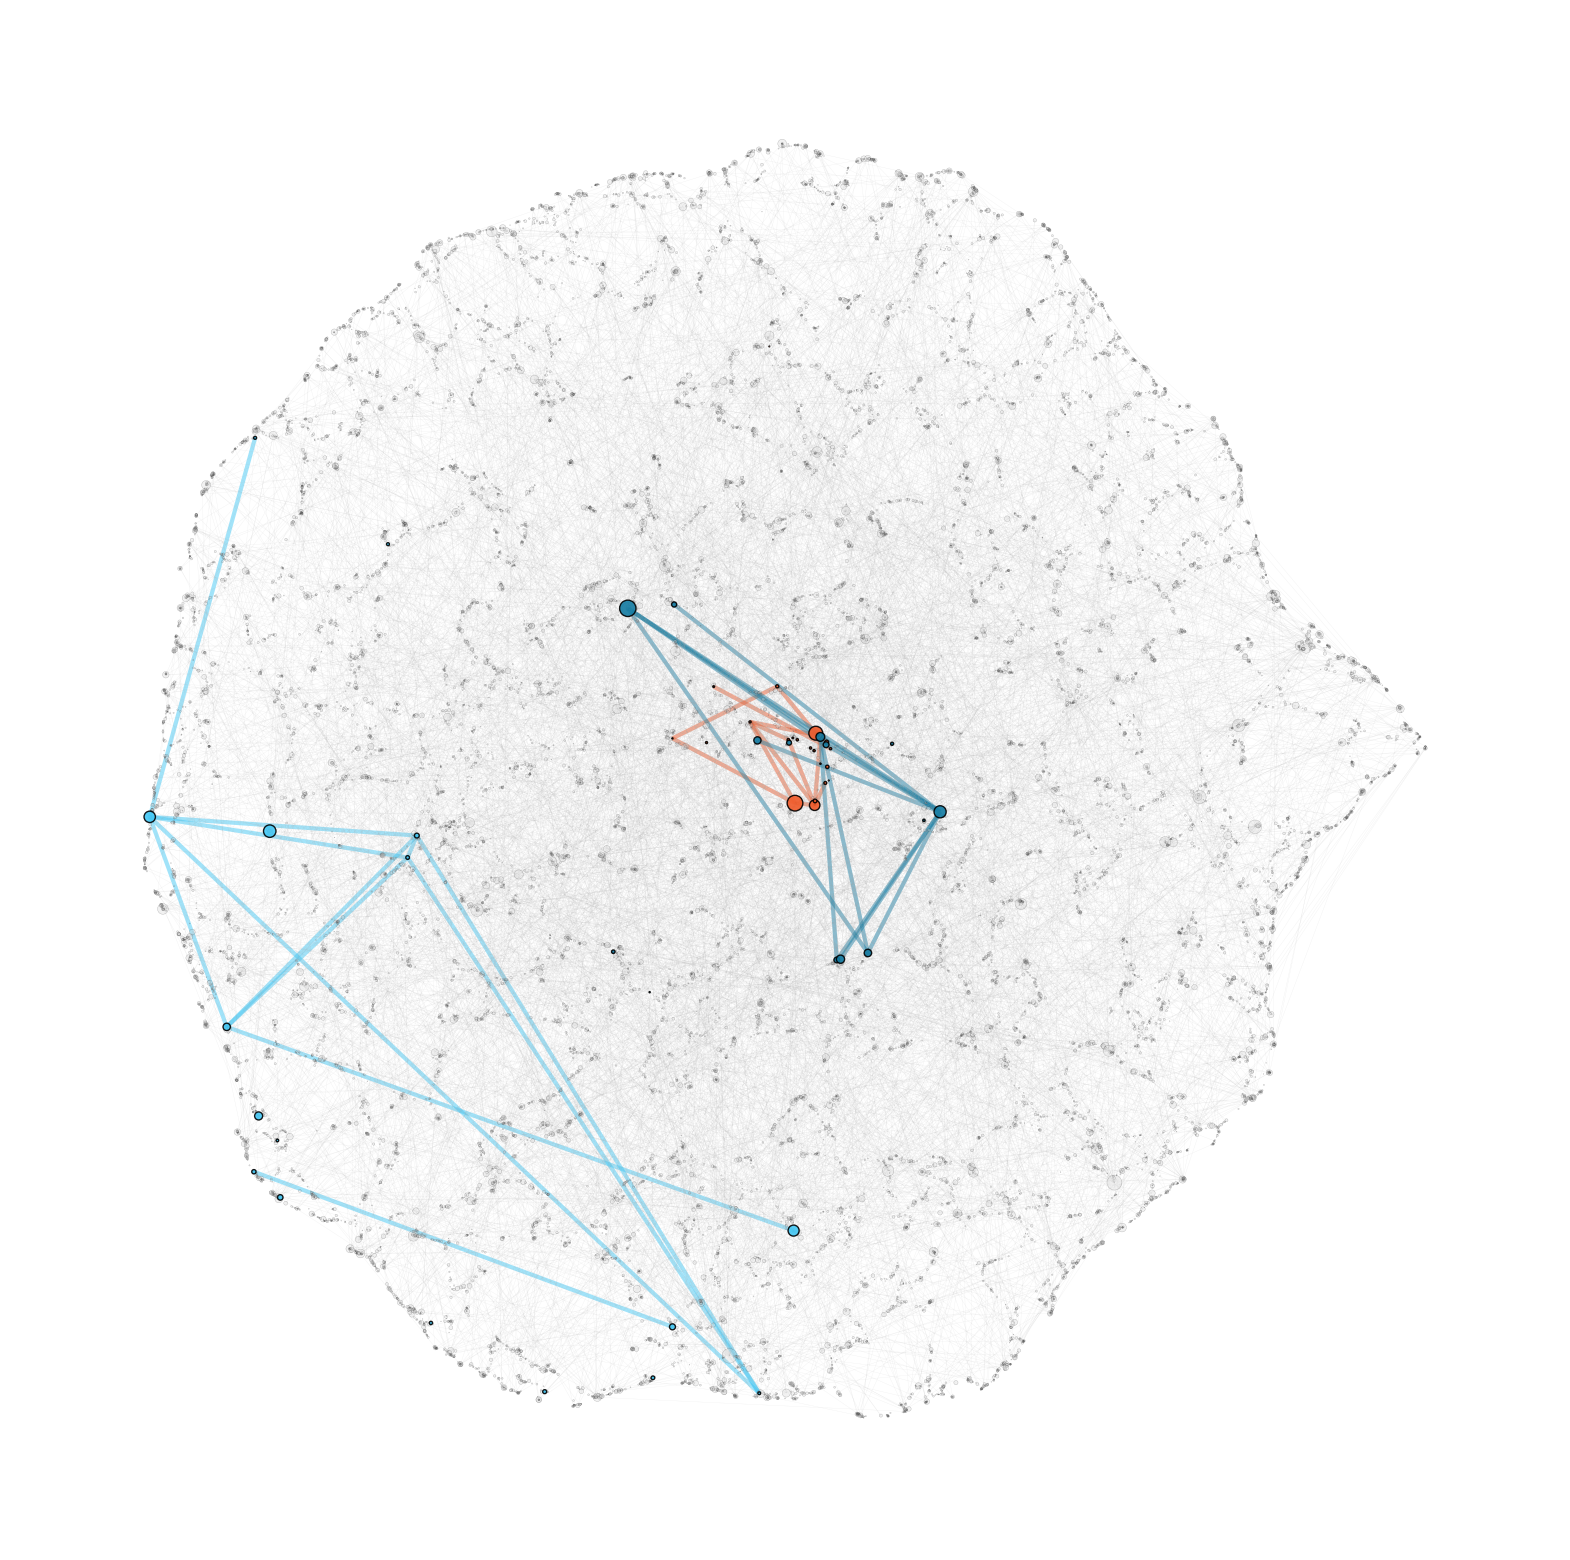

In [22]:
plt.figure(figsize=(20,20))


# specific edges
nx.draw_networkx_edges(G, posG2D, edgelist=edges_1, edge_color=color_1, width=3, alpha=0.5)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_2_diseases, edge_color=color_2_diseases, width=3, alpha=0.5)
nx.draw_networkx_edges(G, posG2D, edgelist=edges_3_diseases, edge_color=color_3_diseases,width=3, alpha=0.5)
# other edges
nx.draw_networkx_edges(G, posG2D, edgelist=list(G.edges())[::100], edge_color='#a9a9a9', width=0.2, alpha=0.2)


# other edges
#nx.draw_networkx_edges(G, posG2D, edgelist=edges_select, edge_color='#a9a9a9', width=0.1, alpha=0.1)

# all nodes
nx.draw_networkx_nodes(G, posG2D, edgecolors=node_edge_col, linewidths=0.25, node_color='#d3d3d3', node_size=node_size, alpha=0.3)

posG2D_1_disease_labels = {}
y_off = 0.01  # offset on the y axis
for k, v in posG2D_1_diseases.items():
    posG2D_1_disease_labels[k] = (v[0], v[1]+y_off)

posG2D_2_disease_labels = {}
for k,v in posG2D_2_diseases.items():
    posG2D_2_disease_labels[k] = (v[0], v[1]+y_off)

posG2D_3_disease_labels = {}
for k,v in posG2D_3_diseases.items():
    posG2D_3_disease_labels[k] = (v[0], v[1]+y_off)

#nx.draw_networkx_labels(G_1, posG2D_1_disease_labels, font_size=10, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_2_diseases, posG2D_2_disease_labels, font_size=10, font_color='black', font_family='sans-serif')
#nx.draw_networkx_labels(G_3_diseases, posG2D_3_disease_labels, font_size=10, font_color='black', font_family='sans-serif')

nx.draw_networkx_nodes(G_1, posG2D_1, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_1, node_size=[i for i in nodesize_1], alpha=0.9)
nx.draw_networkx_nodes(G_2_diseases, posG2D_2_diseases, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_2_diseases, node_size=[i*2 for i in nodesize_2_diseases], alpha=0.9)
nx.draw_networkx_nodes(G_3_diseases, posG2D_3_diseases, edgecolors=node_edge_col, linewidths=node_linewidth, node_color=nodecolor_3_diseases, node_size=[i*10 for i in nodesize_3_diseases], alpha=0.9)


plt.axis('off')  # Optional: to hide the axis

#plt.savefig('test_fig4a.png', dpi=72)
#plt.savefig('Salvo_fig4a.png', dpi=300)


# nx.draw_networkx_labels(G_1, posG2D_1_disease_labels, font_size=10, font_color='black', font_family='sans-serif')
# nx.draw_networkx_labels(G_2_diseases, posG2D_2_disease_labels, font_size=10, font_color='black', font_family='sans-serif')
# nx.draw_networkx_labels(G_3_diseases, posG2D_3_disease_labels, font_size=10, font_color='black', font_family='sans-serif')

# plt.savefig('Salvo_fig4a-withlabels.png', dpi=300)

In [23]:

rows = []

# =====================================================
# -------------------- NODES ---------------------------
# =====================================================

# ---- Background nodes ----
for node, (x, y) in posG2D.items():
    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "background",
        "node_color": "#d3d3d3",
        "node_size": node_size,
        "node_alpha": 0.3,
        "node_edgecolor": node_edge_col,
        "node_linewidth": 0.25,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# ---- G1 highlighted nodes ----
for node, (x, y) in posG2D_1.items():
    idx = list(G_1.nodes()).index(node)

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "G1",
        "node_color": nodecolor_1,
        "node_size": nodesize_1[idx],
        "node_alpha": 0.9,
        "node_edgecolor": node_edge_col,
        "node_linewidth": node_linewidth,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# ---- G2 diseases highlighted nodes ----
for node, (x, y) in posG2D_2_diseases.items():
    idx = list(G_2_diseases.nodes()).index(node)

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "G2_diseases",
        "node_color": nodecolor_2_diseases,
        "node_size": nodesize_2_diseases[idx] * 2,
        "node_alpha": 0.9,
        "node_edgecolor": node_edge_col,
        "node_linewidth": node_linewidth,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# ---- G3 diseases highlighted nodes ----
for node, (x, y) in posG2D_3_diseases.items():
    idx = list(G_3_diseases.nodes()).index(node)

    rows.append({
        "row_type": "node",
        "node_id": node,
        "x": x,
        "y": y,
        "node_layer": "G3_diseases",
        "node_color": nodecolor_3_diseases,
        "node_size": nodesize_3_diseases[idx] * 10,
        "node_alpha": 0.9,
        "node_edgecolor": node_edge_col,
        "node_linewidth": node_linewidth,
        "source": None,
        "target": None,
        "edge_category": None,
        "edge_color": None,
        "edge_width": None,
        "edge_alpha": None
    })


# =====================================================
# -------------------- EDGES ---------------------------
# =====================================================

def append_edges(edgelist, category, color, width, alpha):
    for u, v in edgelist:
        rows.append({
            "row_type": "edge",
            "node_id": None,
            "x": None,
            "y": None,
            "node_layer": None,
            "node_color": None,
            "node_size": None,
            "node_alpha": None,
            "node_edgecolor": None,
            "node_linewidth": None,
            "source": u,
            "target": v,
            "edge_category": category,
            "edge_color": color,
            "edge_width": width,
            "edge_alpha": alpha
        })


# highlighted edges
append_edges(edges_1, "edges_1", color_1, 3, 0.5)
append_edges(edges_2_diseases, "edges_2_diseases", color_2_diseases, 3, 0.5)
append_edges(edges_3_diseases, "edges_3_diseases", color_3_diseases, 3, 0.5)

# sampled background edges
append_edges(list(G.edges())[::100], "sampled", "#a9a9a9", 0.2, 0.2)


# =====================================================
# ---------------- SAVE TO EXCEL ----------------------
# =====================================================

df_disease_network = pd.DataFrame(rows)

print("Nodes saved:", len(df_disease_network[df_disease_network["row_type"]=="node"]))
print("Edges saved:", len(df_disease_network[df_disease_network["row_type"]=="edge"]))

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_disease_network.to_excel(
        writer,
        sheet_name="Fig4A",
        index=False
    )

print("Disease network saved successfully.")

Nodes saved: 18871
Edges saved: 4822
Disease network saved successfully.
